In [20]:
from typing import List, Tuple
from functools import lru_cache

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import wandb

In [21]:
api = wandb.Api()

In [22]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_palette('deep')

In [23]:
keys = [
    "policy_stats/avg_score", 
    "policy_stats/avg_experience_points", 
    # "policy_stats/avg_experience_level", 
    # "policy_stats/avg_max_energy", 
    # "policy_stats/avg_max_hitpoints", 
    "policy_stats/avg_eating_score", 
    "policy_stats/avg_turns", 
    "policy_stats/avg_staircase_score", 
    # "policy_stats/avg_staircase_pet_score", 
    # "policy_stats/avg_armor_class", 
    "policy_stats/avg_scout_score", 
    "policy_stats/avg_dlvl", 
    # "policy_stats/avg_sokobanfillpit_score", 
    "policy_stats/avg_gold_score", 
    "train/env_steps",
]

In [24]:
def get_experiment_data(name, filters):
    runs = api.runs("bartekcupial/sf2_nethack", filters=filters)
    data = []
    for run in runs:
        try:
            df = run.history(samples=30000, keys=keys)
            df = pd.DataFrame(df)
            df["seed"] = run.config["seed"]
            df["name"] = name
            data.append(df)
        except Exception as e:
            pass

    data = pd.concat(data, axis=0).reset_index()
    
    return data

In [25]:
appo_df = get_experiment_data(
    "appo", 
    {"config.exp_tags": "['2024_01_23_monk-APPO-baseline']", "config.learning_rate": 0.0001}
)

In [26]:
appo_t_df = get_experiment_data(
    "appo_t", 
    {"config.exp_tags": "['2024_01_23_monk-APPO-T-baseline2']"}
)

In [27]:
appo_ks_t_df = get_experiment_data(
    "appo_ks_t", 
    {"config.exp_tags": "['2024_01_23_monk-APPO-KS-T-baseline']", "config.kickstarting_loss_decay": 0.99998}
)

In [28]:
appo_bc_t_df = get_experiment_data(
    "appo_bc_t", 
    {"config.exp_tags": "['2024_01_23_monk-APPO-BC-T-baseline']"}
)

In [29]:
appo_ewc_t_df = get_experiment_data(
    "appo_ewc_t", 
    {"config.exp_tags": "['2024_01_29_monk-APPO-EWC-T-baseline']"}
)

In [30]:
data = pd.concat([appo_df, appo_t_df, appo_ks_t_df, appo_bc_t_df, appo_ewc_t_df], axis=0).reset_index()

In [31]:
data

,level_0,index,_step,policy_stats/avg_score,policy_stats/avg_experience_points,policy_stats/avg_eating_score,policy_stats/avg_turns,policy_stats/avg_staircase_score,policy_stats/avg_scout_score,policy_stats/avg_dlvl,policy_stats/avg_gold_score,train/env_steps,seed,name
0,0,0,5,0.000000,0.000000,6.770000,2.270000,0.000000,54.419998,1.00,0.000000,110592.0,4,appo
1,1,1,27,0.420000,0.050000,10.750000,5.490000,0.000000,55.189999,1.00,0.200000,745472.0,4,appo
2,2,2,48,4.920000,0.620000,67.889999,57.919998,0.020000,84.570000,1.04,0.360000,1368064.0,4,appo
3,3,3,69,27.260000,3.440000,159.820007,268.679993,4.360000,154.460007,1.11,5.470000,1994752.0,4,appo
4,4,4,90,38.630001,8.300000,65.080002,1199.069946,5.950000,211.449997,1.05,3.190000,2629632.0,4,appo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32896,3038,618,2212,3790.300049,843.840027,14828.690430,15599.200195,72.669998,760.010010,1.49,235.070007,496447488.0,4,appo_ewc_t
32897,3039,619,2214,3765.510010,835.719971,14532.580078,15283.009766,72.680000,780.750000,1.55,252.380005,497373184.0,4,appo_ewc_t
32898,3040,620,2215,3445.610107,776.489990,13864.469727,14537.429688,73.510002,722.229980,1.47,175.429993,497373184.0,4,appo_ewc_t
32899,3041,621,2217,3540.610107,818.760010,13978.209961,14639.250000,68.900002,729.380005,1.50,155.699997,498323456.0,4,appo_ewc_t


In [32]:
data["index"] = data["train/env_steps"] - data["train/env_steps"] % 5_000_000

In [33]:
data.loc[data["name"] != "appo", "index"] = data[data["name"] != "appo"]["index"] - 25_000_000

In [34]:
data[(data['index'] == 0) & (data['name'].str.contains('_t'))]

,level_0,index,_step,policy_stats/avg_score,policy_stats/avg_experience_points,policy_stats/avg_eating_score,policy_stats/avg_turns,policy_stats/avg_staircase_score,policy_stats/avg_scout_score,policy_stats/avg_dlvl,policy_stats/avg_gold_score,train/env_steps,seed,name
3988,0,0.0,37,4955.220215,1153.119995,15106.040039,15666.709961,58.930000,1045.530029,1.98,361.260010,25309184.0,4,appo_t
3989,1,0.0,60,5150.899902,1192.270020,15140.049805,15715.240234,63.930000,1081.160034,2.01,438.420013,26091520.0,4,appo_t
3990,2,0.0,81,5207.859863,1229.109985,16068.660156,16617.880859,69.370003,1055.000000,2.09,377.390015,26836992.0,4,appo_t
3991,3,0.0,102,4662.439941,1145.630005,15233.000000,15804.030273,55.320000,966.929993,1.97,261.130005,27607040.0,4,appo_t
3992,4,0.0,122,3331.360107,895.359985,12668.360352,13151.929688,42.470001,751.030029,1.44,151.160004,28364800.0,4,appo_t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32280,2422,0.0,77,5016.509766,1137.780029,15594.139648,16286.240234,49.680000,1010.030029,1.81,386.690002,26759168.0,4,appo_ewc_t
32281,2423,0.0,98,4652.459961,1091.640015,14971.769531,15537.830078,50.419998,957.520020,1.71,337.709991,27545600.0,4,appo_ewc_t
32282,2424,0.0,118,4379.640137,1030.949951,14603.650391,15101.809570,55.310001,919.320007,1.64,213.559998,28323840.0,4,appo_ewc_t
32283,2425,0.0,137,4360.640137,1014.989990,14419.179688,14880.440430,49.790001,887.820007,1.61,179.580002,29089792.0,4,appo_ewc_t


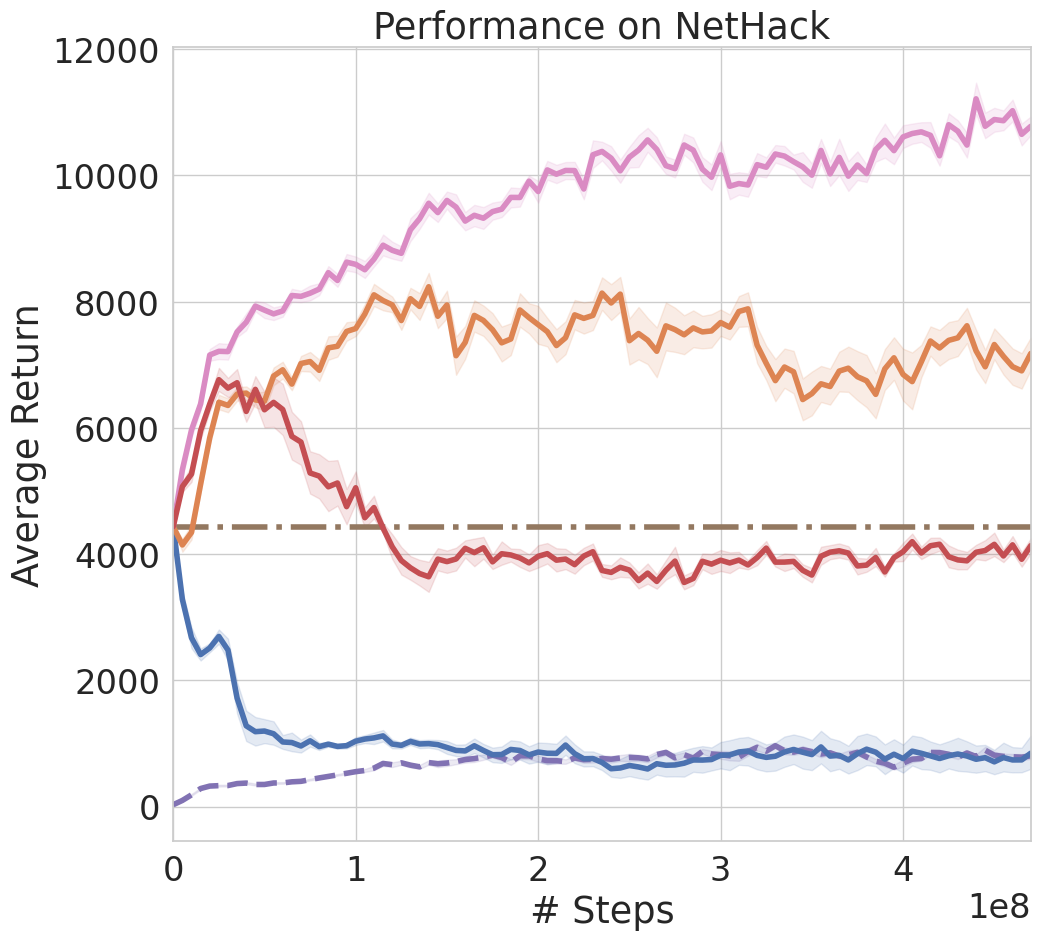

In [35]:
n_rows = 1
n_cols = 1
sns.set(font_scale=2.2)
sns.set_style('whitegrid')

fig, axes = plt.subplots(n_rows, n_cols, figsize=(11, 10))

# axes = axes.flatten()
legend_handles = []  # Create an empty list to collect legend handles
legend_labels = []   # Create an empty list to collect legend labels

method_translator = {
    "appo": "From scratch",
    "appo_t": "Fine-tuning",
    "appo_bc_t": "Fine-tuning + BC",
    "appo_ks_t": "Fine-tuning + KS",
    "appo_ewc_t": "Fine-tuning + EWC",
}


sns_colors = sns.color_palette()
# sns_colors = sns_colors[]
colors = {
    "From scratch": sns_colors[4],
    "Fine-tuning": sns_colors[0],
    "Fine-tuning + BC": sns_colors[1],
    "Fine-tuning + KS": sns_colors[6],
    "Fine-tuning + EWC": sns_colors[3],
}

eval_column = "policy_stats/avg_score"

# [0 - 500M]
baseline_val = data[(data['index'] == 0) & (data['name'].str.contains('_t'))][eval_column].mean()
axes.plot([0, 500_000_000], [baseline_val, baseline_val], linestyle='-.', label="Pre-training", linewidth=4, color=sns_colors[5])
for e, (method, method_name) in enumerate(method_translator.items()):

    method_data = data[data["name"] == method]
    method_data = method_data.replace('NaN', pd.NA).dropna()

    if '_t' in method:
        method_data.loc[method_data['index'] == 0, eval_column] = baseline_val

    legend = "full"
    sns.lineplot(data=method_data, x="index", y=eval_column, ax=axes, errorbar=('ci', 90), linewidth=4,
                    legend=legend, label=method_name, linestyle="-" if method_name != "From scratch" else "--",
                    err_kws={"alpha": .15}, color=colors[method_name])

    axes.set_ylabel("Average Return")

    axes.set_xlabel("# Steps")
    axes.set_xlim(0, 470_000_000)

    axes.set_title(f"Performance on NetHack")

axes.get_legend().remove()
plt.tight_layout()

# Show or save the plot
plt.show()

In [36]:
eval_columns = keys.copy()
del eval_columns[-1]
eval_columns

['policy_stats/avg_score',
 'policy_stats/avg_experience_points',
 'policy_stats/avg_eating_score',
 'policy_stats/avg_turns',
 'policy_stats/avg_staircase_score',
 'policy_stats/avg_scout_score',
 'policy_stats/avg_dlvl',
 'policy_stats/avg_gold_score']

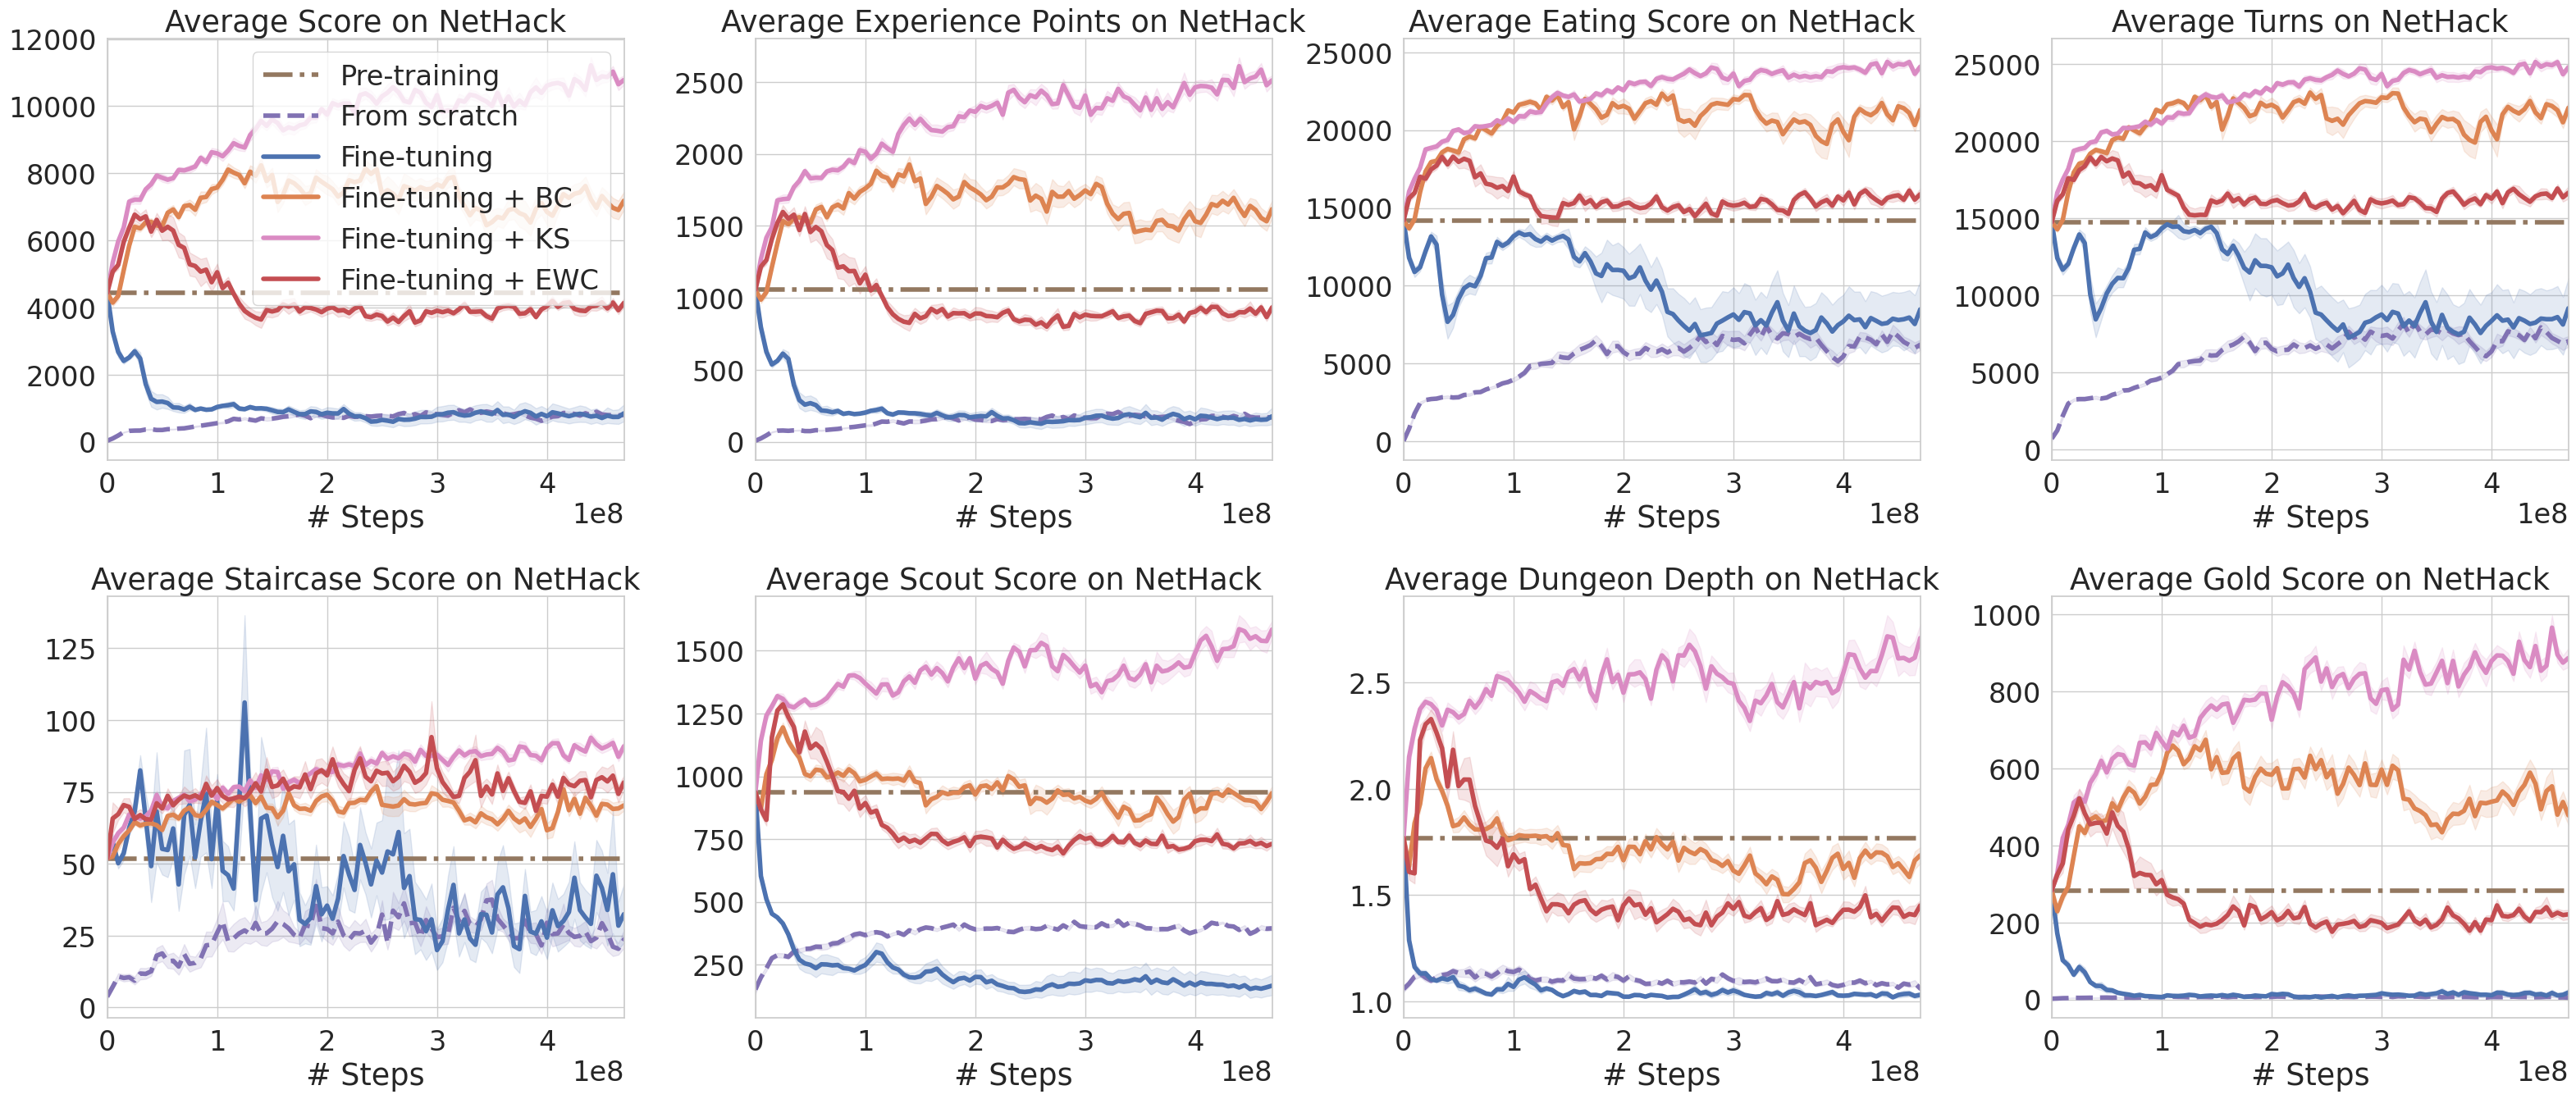

In [38]:
n_rows = 2
n_cols = 4
sns.set(font_scale=2.2)
sns.set_style('whitegrid')

fig, axes = plt.subplots(n_rows, n_cols, figsize=(32, 14))
axes = axes.flatten()

legend_handles = []  # Create an empty list to collect legend handles
legend_labels = []   # Create an empty list to collect legend labels

method_translator = {
    "appo": "From scratch",
    "appo_t": "Fine-tuning",
    "appo_bc_t": "Fine-tuning + BC",
    "appo_ks_t": "Fine-tuning + KS",
    "appo_ewc_t": "Fine-tuning + EWC",
}

sns_colors = sns.color_palette()
# sns_colors = sns_colors[]
colors = {
    "From scratch": sns_colors[4],
    "Fine-tuning": sns_colors[0],
    "Fine-tuning + BC": sns_colors[1],
    "Fine-tuning + KS": sns_colors[6],
    "Fine-tuning + EWC": sns_colors[3],
}

eval_columns_translator = {
    'policy_stats/avg_gold_score': "Gold Score",
    'policy_stats/avg_eating_score': "Eating Score",
    'policy_stats/avg_staircase_score': "Staircase Score",
    'policy_stats/avg_scout_score': "Scout Score",
    'policy_stats/avg_score': "Score",
    'policy_stats/avg_turns': "Turns",
    'policy_stats/avg_experience_points': "Experience Points",
    'policy_stats/avg_dlvl': "Dungeon Depth",
}

for idx, (eval_column, ax) in enumerate(zip(eval_columns, axes)):
    eval_column_name = eval_columns_translator[eval_column]
   
    baseline_val = data[(data['index'] == 0) & (data['name'].str.contains('_t'))][eval_column].mean()
    ax.plot([0, 500_000_000], [baseline_val, baseline_val], linestyle='-.', label="Pre-training", linewidth=4, color=sns_colors[5])
    for e, (method, method_name) in enumerate(method_translator.items()):

        method_data = data[data["name"] == method]
        method_data = method_data[["index", eval_column]]
        # method_data = method_data.replace('NaN', pd.NA).dropna()

        if '_t' in method:
            method_data.loc[method_data['index'] == 0, eval_column] = baseline_val

        # legend = "full"
        legend = "full" if idx == 0 else None
        sns.lineplot(data=method_data, x="index", y=eval_column, ax=ax, errorbar=('ci', 90), linewidth=4,
                        legend=legend, label=method_name, linestyle="-" if method_name != "From scratch" else "--",
                        err_kws={"alpha": .15}, color=colors[method_name])

        # ax.set_ylabel(f"Mean Episode {eval_column_name}")
        ax.set_ylabel("")

        ax.set_xlabel("# Steps")
        ax.set_xlim(0, 470_000_000)

        ax.set_title(f"Average {eval_column_name} on NetHack")

plt.tight_layout()
plt.show()